In [23]:
import numpy as np
import ot
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import h5py

## GRIT Algorithm

In [2]:
def compute_regression_row(YY, XX, D, jg):
    """
    Compute the regression coefficients for a single gene (jg) using weighted ridge regression.
    
    Parameters:
    - YY: ndarray, shape (ndim, N), estimated derivatives for all genes
    - XX: ndarray, shape (ndim + nbr, N), input data matrix
    - D: ndarray, shape (ndim + nbr,), diagonal regularization terms
    - jg: int, index of the current gene
    
    Returns:
    - A_row: ndarray, shape (K,), regression coefficients for gene jg
    """
    # Extract the row for gene jg from YY
    Y = YY[jg, :]  # Shape: (N,)

    # Extract the relevant rows of XX based on TFloc
    X = XX[:]  # Shape: (K, N), where K is the number of True in TFloc

    # Compute weighted Y * X^T
    Y_XT = Y @ X.T  # Shape: (1, K), matrix multiplication

    # Compute weighted X * X^T + regularization
    X_XT = X @ X.T  # Shape: (K, K), matrix multiplication

    # Add regularization term D (diagonal matrix)
    X_XT_reg = X_XT + D  # Shape: (K, K)

    # Solve for A by computing the inverse
    A_row = Y_XT @ np.linalg.inv(X_XT_reg)  # Shape: (1, K)

    return A_row

In [17]:
class GRIT:
    # now we assume uniform time step, same number of cells and weights in the norm D = identity
    def __init__(self, lambda_A=1.0, lambda_b=1.0, epsilon=1e-1, max_iter=10, method='sinkhorn'):
        """
        Initialize GRIT algorithm parameters
        
        Parameters:
        -----------
        lambda_A : float, optional (default=1.0)
            Regularization parameter for matrix A
        lambda_b : float, optional (default=1.0)
            Regularization parameter for vector b
        epsilon : float, optional (default=1e-3)
            Entropy regularization parameter for optimal transport
        max_iter : int, optional (default=100)
            Maximum number of iterations for model identification
        """
        self.lambda_A = lambda_A
        self.lambda_b = lambda_b
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.method = method
        
        # Model parameters to be learned
        self.ntime = None
        self.A = None
        self.b = None
        self.vvs = None  # To store variance weights
        
    def _compute_variance_weights(self, Y_list):
        """
        Compute variance weights (vvs) for each gene and time transition.
        
        Parameters:
        -----------
        Y_list : list of numpy arrays
            Gene expression matrices at different time points
        
        Returns:
        --------
        vvs : numpy array
            Variance weights with shape (n_genes, n_transitions)
        """
        n_genes = Y_list[0].shape[0]
        n_transitions = len(Y_list) - 1
        vvs = np.zeros((n_genes, n_transitions))
        
        ncell = np.array([Y.shape[1] for Y in Y_list])  # Number of cells per time point
        
        # Compute variance for each gene at each transition
        for jt in range(n_transitions):
            mtemp = np.mean(Y_list[jt + 1], axis=1)  # Mean across cells
            mtemp[np.isnan(mtemp)] = 0
            vvs[:, jt] = np.sum((Y_list[jt + 1] - mtemp[:, None]) ** 2, axis=1) / ncell[jt + 1]
        
        # Compute weighted average of variances
        weighted_vvs = np.sum(ncell[1:] * vvs, axis=1) / np.sum(ncell[1:])
        
        # Scale the variances
        vvs = 0.5 + 0.2 * weighted_vvs[:, None] + 0.8 * vvs
        vvs = vvs ** (-0.5)
        
        return vvs

    def OTsolver_MATLABCODE(self, mu0, mu1, C, epsilon, uInit=None):
        """
        Optimal Transport solver using Sinkhorn algorithm with entropic regularization.

        Parameters:
        -----------
        mu0 : array_like
            Source distribution (will be reshaped to column vector)
        mu1 : array_like
            Target distribution (will be reshaped to column vector)
        C : array_like
            Cost matrix
        epsilon : float
            Regularization parameter
        uInit : array_like, optional
            Initial value for dual variable u1

        Returns:
        --------
        transport_cost : float
            The optimal transport cost
        reg_cost : float
            The regularization cost
        M : ndarray
            The optimal transport plan (matrix)
        iteration_count : int
            Number of iterations needed
        u1 : ndarray
            Final dual variable
        """
        # Reshape distributions to column vectors
        mu0 = np.reshape(mu0, (-1, 1))
        mu1 = np.reshape(mu1, (-1, 1))
        

        # Check dimensions
        if abs(mu0.shape[0] - C.shape[0]) + abs(mu1.shape[0] - C.shape[1]) >= 1:
            print('dimension error')
            print(f"mu0 dimension: {mu0.shape}")
            print(f"mu1 dimension: {mu1.shape}")
            print(f"C dimension: {C.shape}")
            return None, None, None, None, None

        # Compute Gibbs kernel
        K = np.exp(-C / epsilon)

        # Initialize dual variables
        if uInit is not None:
            u1 = np.reshape(uInit, (-1, 1))
        else:
            u1 = mu1.copy()

        u0 = mu0.copy()
        u0_old = np.ones_like(u0) * 100  # arbitrary large value
        iteration_count = 0

        # Sinkhorn's algorithm main loop
        while np.linalg.norm(np.log(u0_old + 1e-16) - np.log(u0 + 1e-16)) > 1e-3 and iteration_count < 10000:
            u0_old = u0.copy()
            u0 = mu0 / (K @ u1)  # Element-wise division
            u1 = mu1 / (K.T @ u0)  # Element-wise division, K.T is transpose
            iteration_count += 1

        # Compute optimal transport plan
        # Create diagonal matrices from vectors
        diag_u0 = np.diag(u0.flatten())
        diag_u1 = np.diag(u1.flatten())
        M = diag_u0 @ K @ diag_u1

        # Calculate transport cost
        transport_cost = np.sum(M * C)  # Element-wise product

        # Calculate regularization cost
        M_flat = M.flatten()
        # Add small constant to avoid log(0)
        log_M = np.log(M_flat + 1e-16)
        EE = M_flat * log_M

        # Filter out NaN values (which might occur from log(0))
        valid_indices = ~np.isnan(EE)
        reg_cost = np.sum(EE[valid_indices])

        return transport_cost, reg_cost, M, iteration_count, u1
    
    def optimal_transport_cost(self, Y_prop, Y_next, vvs_t, epsilon, method='sinkhorn'):
        """
        Compute optimal transport cost between propagated and next time point, weighted by vvs.

        Parameters:
        -----------
        Y_prop : numpy array
            Propagated gene expression matrix
        Y_next : numpy array
            Gene expression matrix at next time point
        vvs_t : numpy array
            Variance weights for the current transition
        epsilon : float
            Entropy regularization parameter

        Returns:
        --------
        transport_cost : float
            Optimal transport cost
        transport_plan : numpy array
            Optimal transport plan
        """

        # Compute weighted cost matrix
        # Apply vvs_t element-wise to scale the gene expressions
        Y_prop_weighted = vvs_t[:, None] * Y_prop  # Reshape vvs_t to (G, 1) for broadcasting
        Y_next_weighted = vvs_t[:, None] * Y_next  # Reshape vvs_t to (G, 1) for broadcasting

        # Compute cost matrix as squared Euclidean distance
        cost_matrix = ot.dist(Y_prop_weighted.T, Y_next_weighted.T)

        # Uniform weights
        a = np.ones(Y_prop.shape[1]) / Y_prop.shape[1]
        b = np.ones(Y_next.shape[1]) / Y_next.shape[1]
        
#         
#         # Solve optimal transport problem by skinhorn
#         transport_plan = ot.sinkhorn(a, b, cost_matrix, epsilon, method=method)

#         # Compute transport cost
#         transport_cost = np.sum(transport_plan * cost_matrix)
        transport_cost, _, transport_plan, _,_ = self.OTsolver_MATLABCODE(a, b, cost_matrix, epsilon)
        return transport_cost, transport_plan
    
    def _estimate_derivatives(self, Y_list, transport_plans, vvs):
        """
        Estimate cell derivatives using transport plans, weighted by vvs.
        
        Parameters:
        -----------
        Y_list : list of numpy arrays
            Gene expression matrices at different time points
        transport_plans : list of numpy arrays
            Optimal transport plans between consecutive time points
        vvs : numpy array
            Variance weights
        
        Returns:
        --------
        Z : numpy array
            Estimated derivatives
        """
        
        Z = []
        for k in range(len(Y_list) - 1):
            Y_k = Y_list[k]
            Y_next = Y_list[k+1]
            M_k = transport_plans[k]
            delta_t = 1.0  # Assuming uniform time steps
            
            # Compute target points
            target_points = Y_next @ M_k.T
            
            # Compute derivatives, weighted by vvs for the k-th transition
            derivatives = (target_points - Y_k) / delta_t
            
            # Apply vvs_k to scale the derivatives (optional, depending on intent)
            vvs_k = vvs[:, k]  # Shape (n_genes,)
            derivatives = vvs_k[:, None] * derivatives  # Element-wise scaling
            Z.append(derivatives)
        
        return np.hstack(Z)
    
    def fit(self, Y_list, time_points=None):
        """
        Fit GRIT model to single-cell time series data
        
        Parameters:
        -----------
        Y_list : list of numpy arrays
            Gene expression matrices at different time points
        time_points : array-like, optional
            Time points corresponding to Y_list
        
        Returns:
        --------
        self : GRIT object
        """
        # Get number of genes
        n_genes = Y_list[0].shape[0]
        self.ntime = len(Y_list)
        
        # Initialize A and b
        self.A = np.ones((n_genes,n_genes)) 
        self.b = np.zeros(n_genes)
        
        # Compute variance weights
        self.vvs = self._compute_variance_weights(Y_list)
        
        # Coordinate descent optimization
        for iteration in range(self.max_iter):
            transport_plans = []
            total_transport_cost = 0
            
            # Compute transport plans
            for k in range(self.ntime - 1):
                Y_prop = (np.eye(n_genes) + self.A) @ Y_list[k] + self.b.reshape(-1, 1)
                Y_next = Y_list[k+1]
                
                transport_cost, transport_plan = self.optimal_transport_cost(
                    Y_prop, Y_next, self.vvs[:, k], self.epsilon, self.method)
                transport_plan = transport_plan / transport_plan.sum(1,keepdims=True)
                transport_plans.append(transport_plan)
                total_transport_cost += transport_cost
            transport_plans = np.array(transport_plans)
#            print('Total cost', iteration, total_transport_cost)
            
            # Estimate derivatives
            Z = self._estimate_derivatives(Y_list, transport_plans, self.vvs)
            
            # Solve row-wise regression
            A_new = 0*np.eye(n_genes)
            b_new = 0*np.ones(n_genes)
            
            # Solve row-wise regression
            for i in range(n_genes):
                # Construct augmented matrix
                Y_list_concat = np.hstack(Y_list[:-1])
                Y_augmented = np.vstack([Y_list_concat, np.ones(Y_list_concat.shape[1])])
                
                # Constructed regression
                reg_term = np.eye(n_genes+1)
                reg_term[:-1, :-1] *= self.lambda_A
                reg_term[-1, -1] = self.lambda_b
                
                # Solve least squares with variance weighting
                # Weight the derivatives and data by vvs for the i-th gene
                vvs_weight = self.vvs[i, :]  # Variance weights for gene i across transitions
                Z_weighted = Z[i, :] * np.repeat(vvs_weight,Y_list[0].shape[1])  # Weight the derivatives
                vvs_augmented = np.vstack([self.vvs,np.ones(self.ntime-1)])
                Y_augmented_weighted = Y_augmented * np.repeat(vvs_augmented,Y_list[0].shape[1],axis=1)  # Weight the design matrix
                
                X = Y_augmented_weighted.T
                y = Z_weighted
                solution = np.linalg.lstsq(X.T @ X + reg_term, X.T @ y, rcond=None)[0]
                
#                 print(i, Z[i, :] @  Y_augmented.T - (Y_augmented @ Y_augmented.T + reg_term) @ solution)
                
#                 # Solve Ridge regression
#                 ridge = Ridge(alpha=self.lambda_b)  # Use lambda_b as the regularization strength
#                 ridge.fit(Y_augmented.T, Z[i, :])  # Fit the model
#                 solution = ridge.coef_
#                 derivative = Y_augmented @ Z[i, :].T - solution @ (reg_term + Y_augmented @ Y_augmented.T)
#                print(i,derivative)

#                 # Use the algorithm from reference
#                 solution = compute_regression_row(Z, Y_augmented, reg_term, i)
    
                # Collect results for A_new and b_new
                A_new[i, :] = solution[:n_genes]
                b_new[i] = solution[-1]

            # update A and b
            kappa = min(0.5 + 0.7 * iteration / self.max_iter, 1.0)
            A_prev = self.A.copy()
            b_prev = self.b.copy()
            self.A = (1 - kappa) * A_prev + kappa * A_new
            self.b = (1 - kappa) * b_prev + kappa * b_new
            # Check for convergence
            if iteration > 0:
                A_diff = np.linalg.norm(self.A - A_prev)
                b_diff = np.linalg.norm(self.b - b_prev)
                if A_diff < 1e-6 and b_diff < 1e-6:
                    print(f"Converged after {iteration+1} iterations")
                    break
            
            if iteration % 5 == 0 or iteration == self.max_iter - 1:
                print(f"Iteration {iteration+1}/{self.max_iter}, Transport cost: {total_transport_cost:.4f}")
                
        return self
    
    def predict_network(self, threshold=0.5):
        """
        Predict gene regulatory network based on learned A matrix
        
        Parameters:
        -----------
        threshold : float, optional
            Threshold for considering a regulatory link
        
        Returns:
        --------
        network : numpy array
            Binary adjacency matrix representing the network
        """
        network = np.abs(self.A) > threshold
        return network.astype(int)

In [18]:
def generate_discrete_time_system_data(A_true, b_true, x0, n_timepoints, n_cells, epsilon, shuffle=False):
    """
    Generate synthetic data based on the discrete-time system equation
    
    Parameters:
    -----------
    A_true : numpy array
        True system matrix
    b_true : numpy array
        True constant load vector
    x0 : numpy array
        Initial distribution mean
    n_timepoints : int
        Number of time points to generate
    n_cells : int
        Number of cells per time point
    epsilon : float
        Noise intensity
    
    Returns:
    --------
    Y_list : list of numpy arrays
        Generated gene expression matrices at different time points
    """
    n_genes = A_true.shape[0]
    Y_list = []
    
    # Generate initial time point
    x0_samples = np.random.multivariate_normal(x0, np.eye(n_genes), n_cells).T
    Y_list.append(x0_samples)
    
    # Generate subsequent time points
    for _ in range(1, n_timepoints):
        prev_timepoint = Y_list[-1]
        
        # Propagate cells
        noise = np.sqrt(epsilon) * np.random.randn(n_genes, n_cells)
        next_timepoint = (np.eye(n_genes) + A_true) @ prev_timepoint + b_true.reshape(-1, 1) + noise
        
        Y_list.append(next_timepoint)
        if shuffle:
            np.random.shuffle(Y_list[-1].T) # shuffle cell id

    
    return Y_list

## TEST CASES

Text(0, 0.5, 'Gene Value')

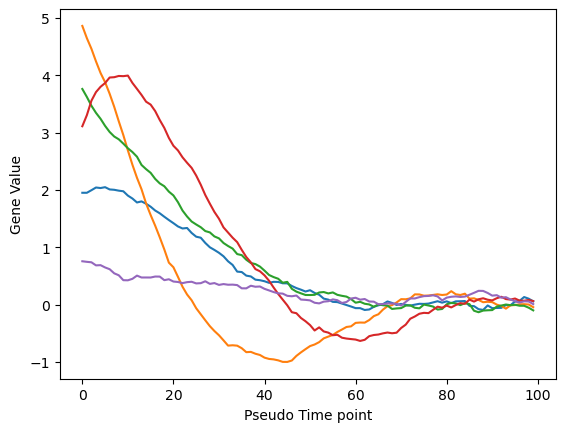

In [19]:
np.random.seed(42)
    
# Define system parameters
n_genes = 5
n_cells = 100
n_timepoints = 100
epsilon = 0.1

# Create true system matrix A and constant load vector b
A_true = 0.1*np.array([
    [-0.5,  0.2,    0,    0,    0],
    [ 0.1, -0.1,  0.3, -0.8,    0],
    [   0,  0.1, -0.7,  0.2,    0],
    [   0,  0.8,  0.2, -0.8,  0.1],
    [   0,    0,    0,  0.1, -0.9]])
#A_true = -0.3*np.eye(n_genes)
#np.fill_diagonal(A_true[1:], -0.5)
#np.fill_diagonal(A_true[3:], 0.1)
b_true = 0*np.ones(n_genes)

# Initial distribution mean
x0 = np.random.random(n_genes)*5

# Generate synthetic data
Y_list = generate_discrete_time_system_data(
    A_true, b_true, x0, n_timepoints, n_cells, epsilon, shuffle=True
)
plt.plot(np.mean(Y_list,2))
plt.xlabel("Pseudo Time point")
plt.ylabel("Gene Value")

In [20]:
# Initialize and fit GRIT
grit = GRIT(lambda_A=0.001, lambda_b=0.001, epsilon=0.05, max_iter=30, method='sinkhorn')
grit.fit(Y_list);

/var/folders/4b/c12275gj0wnfbxszh_y34rd80000gp/T/ipykernel_84423/1665467204.py:124: RuntimeWarning: divide by zero encountered in divide
  u0 = mu0 / (K @ u1)  # Element-wise division
/var/folders/4b/c12275gj0wnfbxszh_y34rd80000gp/T/ipykernel_84423/1665467204.py:125: RuntimeWarning: invalid value encountered in matmul
  u1 = mu1 / (K.T @ u0)  # Element-wise division, K.T is transpose
/var/folders/4b/c12275gj0wnfbxszh_y34rd80000gp/T/ipykernel_84423/1665467204.py:124: RuntimeWarning: overflow encountered in divide
  u0 = mu0 / (K @ u1)  # Element-wise division


Iteration 1/30, Transport cost: nan
Iteration 6/30, Transport cost: nan
Iteration 11/30, Transport cost: nan
Iteration 16/30, Transport cost: nan
Iteration 21/30, Transport cost: nan
Iteration 26/30, Transport cost: nan
Iteration 30/30, Transport cost: nan


True A matrix:
[[-0.05  0.02  0.    0.    0.  ]
 [ 0.01 -0.01  0.03 -0.08  0.  ]
 [ 0.    0.01 -0.07  0.02  0.  ]
 [ 0.    0.08  0.02 -0.08  0.01]
 [ 0.    0.    0.    0.01 -0.09]]

Relative difference of A:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
True b vector:
[0. 0. 0. 0. 0.]

Relative difference of b:
[nan nan nan nan nan]


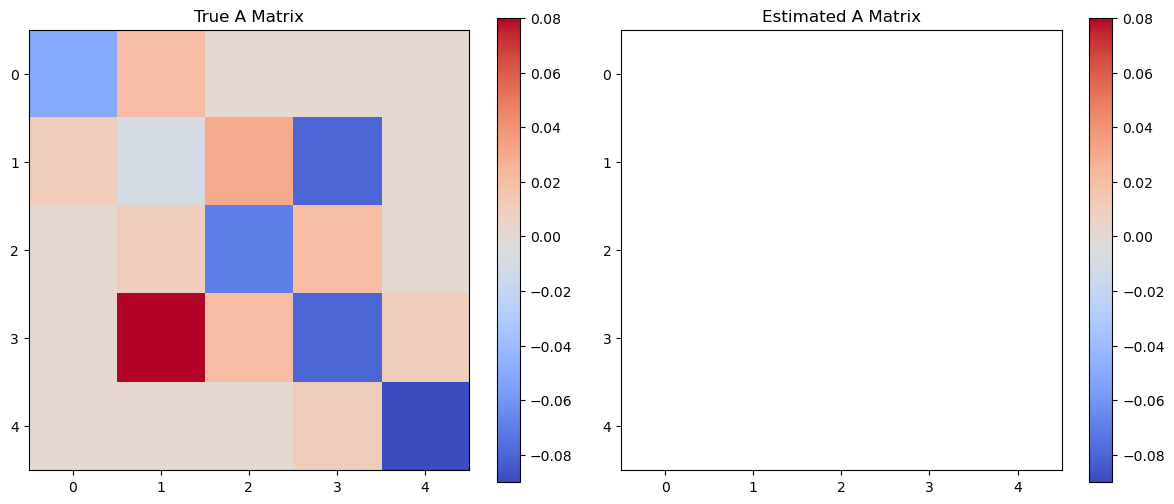

In [21]:
# Compare true and estimated A matrices
print("True A matrix:")
print(A_true)
diff_A = np.abs(A_true  - grit.A)
print("\nRelative difference of A:")
print(diff_A / A_true)

print("True b vector:")
print(b_true)
diff_b = np.abs(b_true - grit.b)
print("\nRelative difference of b:")
print(diff_b / b_true)

# Visualize the differences
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("True A Matrix")
plt.imshow(A_true, cmap='coolwarm', interpolation='nearest',vmax=np.max(A_true),vmin=np.min(A_true))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated A Matrix")
plt.imshow(grit.A, cmap='coolwarm', interpolation='nearest',vmax=np.max(A_true),vmin=np.min(A_true))
plt.colorbar()

plt.tight_layout()
plt.show()

In [12]:
grit.b

array([ 0.00120084, -0.00099075, -0.00144239, -0.00106952,  0.00403746])

In [42]:
import numpy as np

def create_modified_identity(n):
    # Create an identity matrix of size n x n
    matrix = np.eye(n)
    
    # Add 1 to the subdiagonal (elements just below the main diagonal)
    np.fill_diagonal(matrix[1:], 1)
    
    return matrix

# Example usage
n = 5  # You can set n to any desired size
modified_identity = create_modified_identity(n)
print(modified_identity)

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]]


1. start with A true and calculate J(A,b) in eq 3
2. set A_true as initial condition and the algorithm should converge in 1 step. Compare J(A,b) with what you calculated 
3. change A a little to see if the algorithm is working 

number of particles goes to infinity and the error goes to zero and how fast. 

marginals are important and we can't get rid of that

1. make sure the OT is working with/without entropic with far apart trajectories that the mathes are clear.
2. test simple benchmark in the paper. Discrete dynsmics, norm of the error. 
3. BEELINE paper